In [35]:
# importing dependencies here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing and pipeline
import re
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# ML models and Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_validate

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump

# code formatter
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
# reading the email data
df = pd.read_csv("../data/emails.csv")

<IPython.core.display.Javascript object>

In [3]:
# checking first 5 records
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


<IPython.core.display.Javascript object>

## EDA

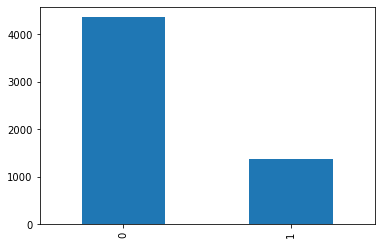

<IPython.core.display.Javascript object>

In [4]:
# checking for class imbalance
df["spam"].value_counts().plot(kind="bar")

* Class 1 = Spam
* Class 0 = Ham
#### The dataset is imbalanced. I will handle class imbalance in the model pipeline.

### Checking for Null Values

In [5]:
df.isnull().sum()

text    0
spam    0
dtype: int64

<IPython.core.display.Javascript object>

### Some quick Stats check

In [28]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        5728 non-null   object
 1   spam        5728 non-null   int64 
 2   clean_text  5728 non-null   object
dtypes: int64(1), object(2)
memory usage: 134.4+ KB
None
              spam
count  5728.000000
mean      0.238827
std       0.426404
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


<IPython.core.display.Javascript object>

### Data Cleaning

In [7]:
# converting posts into lower case
df["clean_text"] = df["text"].str.lower()

df["clean_text"] = df["clean_text"].str.replace(
    re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*"), ""
)

# dropping emails
df["clean_text"] = df["clean_text"].str.replace(re.compile(r"\S+@\S+"), "")

# dropping punctuations
df["clean_text"] = df["clean_text"].str.replace(re.compile(r"[^a-z\s]"), " ")

# dropping the word "subject"
df["clean_text"] = df["clean_text"].str.replace("subject", "")

<IPython.core.display.Javascript object>

In [8]:
df.head()

,text,spam,clean_text
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identi...
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merri...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting...
3,Subject: 4 color printing special request add...,1,color printing special request additional...
4,"Subject: do not have money , get software cds ...",1,do not have money get software cds from he...


<IPython.core.display.Javascript object>

## Building ML Model

In [9]:
X = df["clean_text"].values
y = df["spam"].values

<IPython.core.display.Javascript object>

In [47]:
def build_model(model, X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # model training
    model.fit(X_train, y_train)

    # y_hat
    y_pred = model.predict(X_test)

    # model evaluation
    print(classification_report_imbalanced(y_test, y_pred))

    cross_validation_report(model, X, y)


########################################################################################################


def build_proba_model(model, X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # model training
    model.fit(X_train, y_train)

    # y_hat
    y_pred = model.predict(X_test)

    # y_probability
    y_proba = model.predict_proba(X_test)[:, 1]

    # precision recall score
    average_precision = average_precision_score(y_test, y_proba)

    # model evaluation
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
    print(f"Average Precision-Recall Score: {average_precision:.2f}")
    print(classification_report_imbalanced(y_test, y_pred))

    cross_validation_report(model, X, y)


#####################################################################################################


def cross_validation_report(model, X, y):

    raw_cv_report = cross_validate(
        model, X, y, cv=5, scoring=("accuracy", "precision", "recall")
    )

    cv_report = {f"Avg {key:.2f}": raw_cv_report[key].mean() for key in raw_cv_report}

    print("Cross Validation Report:\n--------------------------------")
    for key in cv_report:
        print(f"{key}: {cv_report[key]}")

    return

<IPython.core.display.Javascript object>

## Naive Bayes using Count Vectorizer

In [48]:
ct_nb = imb_make_pipeline(
    CountVectorizer(min_df=25, max_df=0.85, stop_words="english"),
    RandomOverSampler(),
    MultinomialNB(class_prior=None, fit_prior=True),
)

build_proba_model(ct_nb, X, y)

ROC-AUC Score: 0.99
Average Precision-Recall Score: 0.97
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.98      0.98      0.99      0.98      0.96       872
          1       0.94      0.98      0.98      0.96      0.98      0.96       274

avg / total       0.98      0.98      0.98      0.98      0.98      0.96      1146

Cross Validation Report:
------------------------
Avg fit_time: 0.9182470321655274
Avg score_time: 0.2260404109954834
Avg test_accuracy: 0.9818436635496924
Avg test_precision: 0.9464425319683372
Avg test_recall: 0.9795379802679072


<IPython.core.display.Javascript object>

## Naive Bayes using TF-IDF Vectorizer

In [31]:
tf_nb = imb_make_pipeline(
    TfidfVectorizer(min_df=25, max_df=0.85, stop_words="english"),
    RandomOverSampler(),
    MultinomialNB(class_prior=None, fit_prior=True),
)

build_proba_model(tf_nb, X, y)

ROC-AUC Score: 1.00
Average Precision-Recall Score: 0.99
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.98      0.99      0.98      0.97       872
          1       0.95      0.98      0.99      0.97      0.98      0.97       274

avg / total       0.98      0.98      0.98      0.98      0.98      0.97      1146

Avg fit_time: 0.9175310929616293
Avg score_time: 0.4158934752146403
Avg test_accuracy: 0.9804470785486585
Avg test_precision: 0.942969945393386
Avg test_recall: 0.9773391812865496


<IPython.core.display.Javascript object>

## Gaussian Naive Bayes using TF-IDF Vectorizer

In [38]:
tf_gaussian_nb = imb_make_pipeline(
    TfidfVectorizer(min_df=25, max_df=0.85, stop_words="english"),
    RandomOverSampler(),
    DenseTransformer(),
    GaussianNB(),
)

build_proba_model(tf_gaussian_nb, X, y)

ROC-AUC Score: 0.93
Average Precision-Recall Score: 0.87
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.99      0.85      0.97      0.92      0.86       872
          1       0.97      0.85      0.99      0.91      0.92      0.83       274

avg / total       0.96      0.96      0.88      0.96      0.92      0.85      1146

Avg fit_time: 0.8335017363230387
Avg score_time: 0.3876917362213135
Avg test_accuracy: 0.9581015617215046
Avg test_precision: 0.9629417716639765
Avg test_recall: 0.8574561403508771


<IPython.core.display.Javascript object>

## SVM with Count Vectorizer

### RBF kernel with variations of C 

In [49]:
# C = 1 (default) 
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), svm.SVC(kernel="rbf", C=1)
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.97      0.97      0.98      0.97      0.94       872
          1       0.90      0.97      0.97      0.94      0.97      0.94       274

avg / total       0.97      0.97      0.97      0.97      0.97      0.94      1146

Cross Validation Report:
------------------------
Avg fit_time: 10.977053451538087
Avg score_time: 1.7871066570281982
Avg test_accuracy: 0.9720673388356692
Avg test_precision: 0.9221675753421122
Avg test_recall: 0.9648966605170985


<IPython.core.display.Javascript object>

In [39]:
# C = 10
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), svm.SVC(kernel="rbf", C=10)
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.97      0.99      0.98      0.96       872
          1       0.96      0.97      0.99      0.97      0.98      0.96       274

avg / total       0.98      0.98      0.98      0.98      0.98      0.96      1146

Avg fit_time: 6.021752595901489
Avg score_time: 1.985026200612386
Avg test_accuracy: 0.9849856973992029
Avg test_precision: 0.9755313596461734
Avg test_recall: 0.9612573099415206


<IPython.core.display.Javascript object>

In [46]:
# C = 100
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), svm.SVC("rbf", C=100)
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.99      0.95      0.99      0.97      0.95       872
          1       0.97      0.95      0.99      0.96      0.97      0.94       274

avg / total       0.98      0.98      0.96      0.98      0.97      0.94      1146

Avg fit_time: 5.872753938039144
Avg score_time: 1.912200133005778
Avg test_accuracy: 0.9806215071988387
Avg test_precision: 0.9736579613826638
Avg test_recall: 0.9444444444444445


<IPython.core.display.Javascript object>

### Linear kernel with variations of C 

In [50]:
# C = 1 (default)
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), svm.SVC(kernel="linear", C=1)
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.97      0.99      0.98      0.96       872
          1       0.97      0.97      0.99      0.97      0.98      0.96       274

avg / total       0.99      0.99      0.98      0.99      0.98      0.96      1146

Cross Validation Report:
------------------------
Avg fit_time: 4.375637817382812
Avg score_time: 0.6784913539886475
Avg test_accuracy: 0.9844629887895623
Avg test_precision: 0.9671496223145677
Avg test_recall: 0.967848453249913


<IPython.core.display.Javascript object>

In [51]:
# C = 10
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), svm.SVC(kernel="linear", C=10)
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.96      0.97      0.98      0.97      0.94       872
          1       0.89      0.97      0.96      0.93      0.97      0.94       274

avg / total       0.97      0.97      0.97      0.97      0.97      0.94      1146

Cross Validation Report:
------------------------
Avg fit_time: 11.228559112548828
Avg score_time: 1.7902807235717773
Avg test_accuracy: 0.9731144592545172
Avg test_precision: 0.9253342977161638
Avg test_recall: 0.9656265875243978


<IPython.core.display.Javascript object>

In [52]:
# C = 100
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"),
    RandomOverSampler(),
    svm.SVC(kernel="linear", C=100),
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.97      0.99      0.98      0.96       872
          1       0.97      0.97      0.99      0.97      0.98      0.96       274

avg / total       0.99      0.99      0.98      0.99      0.98      0.96      1146

Cross Validation Report:
------------------------
Avg fit_time: 4.376210403442383
Avg score_time: 0.6591748237609864
Avg test_accuracy: 0.9844629887895623
Avg test_precision: 0.9671496223145677
Avg test_recall: 0.967848453249913


<IPython.core.display.Javascript object>

### Poly kernel with variations of C

In [53]:
# C = 1, default degree = 3
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), svm.SVC(kernel="poly", C=1, degree=3)
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.33      0.99      0.49      0.57      0.30       872
          1       0.32      0.99      0.33      0.48      0.57      0.34       274

avg / total       0.83      0.48      0.83      0.49      0.57      0.31      1146

Cross Validation Report:
------------------------
Avg fit_time: 26.939928674697875
Avg score_time: 3.9504950523376463
Avg test_accuracy: 0.495809841712583
Avg test_precision: 0.3203329706536275
Avg test_recall: 0.9897676532713028


<IPython.core.display.Javascript object>

In [54]:
# C = 10
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"),
    RandomOverSampler(),
    svm.SVC(kernel="poly", C=10, degree=3),
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.52      0.99      0.68      0.71      0.48       872
          1       0.39      0.99      0.52      0.56      0.71      0.53       274

avg / total       0.85      0.63      0.87      0.65      0.71      0.50      1146

Cross Validation Report:
------------------------
Avg fit_time: 25.036382961273194
Avg score_time: 3.6159300804138184
Avg test_accuracy: 0.6346049673441703
Avg test_precision: 0.39430165034596315
Avg test_recall: 0.9839148685864014


<IPython.core.display.Javascript object>

In [55]:
# C = 100
svm_pipe = imb_make_pipeline(
    CountVectorizer(stop_words="english"), RandomOverSampler(), svm.SVC(kernel="poly", C=100, degree=3)
)
build_model(svm_pipe, X, y)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.65      0.97      0.79      0.80      0.62       872
          1       0.47      0.97      0.65      0.63      0.80      0.66       274

avg / total       0.86      0.73      0.90      0.75      0.80      0.63      1146

Cross Validation Report:
------------------------
Avg fit_time: 19.893043279647827
Avg score_time: 2.734015941619873
Avg test_accuracy: 0.7522775250158136
Avg test_precision: 0.4914738298985132
Avg test_recall: 0.9766075773375043


<IPython.core.display.Javascript object>